# Import packages
run the following cell to import necessary packages to run the analysis

In [1]:
import os
from pathlib import Path
import zipfile
import xarray as xr

from tqdm.notebook import tqdm
import numpy as np
import dask.diagnostics
import ngff_zarr
import dask.array as da
import tifffile
from multiview_stitcher import spatial_image_utils as si_utils
from multiview_stitcher import (
    fusion,
    io,
    msi_utils,
    vis_utils,
    ngff_utils,
    param_utils,
    registration
)

# Reading data

In [2]:
# data_path = Path('/mnt/Data/nuno_martins/Image_data/Ex011_Re01/ExM/sample_data/')
data_path = Path('/mnt/Data/nuno_martins/Image_data/Ex010_Re01/ExM/20250417_2/Airyscan_processed/split_czi/')
filelist = os.listdir(data_path)
print(len(filelist))

21


In [3]:
filelist = [x for x in filelist if x.find('.czi')>0]
filelist.sort()
filelist

['gel4c_-01-5_AcquisitionBlock1_pt1_sub1-Scene-1-Airyscan Processing-01_2_tile01.czi',
 'gel4c_-01-5_AcquisitionBlock1_pt1_sub1-Scene-1-Airyscan Processing-01_2_tile02.czi',
 'gel4c_-01-5_AcquisitionBlock1_pt1_sub2-Scene-1-Airyscan Processing-02_2_tile01.czi',
 'gel4c_-01-5_AcquisitionBlock1_pt1_sub2-Scene-1-Airyscan Processing-02_2_tile02.czi',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan Processing-07_2_tile01.czi',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan Processing-07_2_tile02.czi',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan Processing-07_2_tile03.czi',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan Processing-07_2_tile04.czi',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub2-Scene-1-Airyscan Processing-08_2_tile01.czi',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub2-Scene-1-Airyscan Processing-08_2_tile02.czi',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub2-Scene-1-Airyscan Processing-08_2_tile03.czi',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub2-Sc

In [4]:
tiles = range(4,8)
filelist_tiles = [filelist[i] for i in tiles]
filelist_tiles

['gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan Processing-07_2_tile01.czi',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan Processing-07_2_tile02.czi',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan Processing-07_2_tile03.czi',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan Processing-07_2_tile04.czi']

In [5]:
filelist_tiles_save = [x[:x.index('.czi')].replace(" ", "_") for x in filelist_tiles]
filelist_tiles_save

['gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan_Processing-07_2_tile01',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan_Processing-07_2_tile02',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan_Processing-07_2_tile03',
 'gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan_Processing-07_2_tile04']

In [6]:

def get_filename_from_tile_and_channel(tile):
    """
    This convenience function returns the filename given the tile and channel.
    """
    return data_path / f'{tile}'

print('Example filename:\n', get_filename_from_tile_and_channel(filelist_tiles[0]))

Example filename:
 /mnt/Data/nuno_martins/Image_data/Ex010_Re01/ExM/20250417_2/Airyscan_processed/split_czi/gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan Processing-07_2_tile01.czi


In [7]:
save_path = Path(str(data_path)+'/stitched_files/')
save_path.mkdir(parents=True, exist_ok=True)
print(save_path)

/mnt/Data/nuno_martins/Image_data/Ex010_Re01/ExM/20250417_2/Airyscan_processed/split_czi/stitched_files


___
# Arranging tiles on a grid


In [8]:
# indicate how the tile index maps onto the grid position for each tile index
# (as a function of the tile index)
# examples:
#  get_tile_grid_position_from_tile_index(0) -> {'z': 0, 'y': 0, 'x': 0}
#  get_tile_grid_position_from_tile_index(1) -> {'z': 0, 'y': 0, 'x': 1}
#  get_tile_grid_position_from_tile_index(2) -> {'z': 0, 'y': 1, 'x': 0}
#  etc.
num_cols = 2

def get_tile_grid_position_from_tile_index(tile_index, z_index=0, num_xy_columns=num_cols):
    # num_xy_columns = 2
    return {
        'z': z_index, # all tiles are on the same z position
        'y': tile_index // num_xy_columns,
        'x': tile_index % num_xy_columns if (tile_index // num_xy_columns) % 2 == 0 else num_xy_columns - 1 - (tile_index % num_xy_columns)
    }

print("Tile grid indices:")
print("\n".join([f"Tile {itile}: " + str(get_tile_grid_position_from_tile_index(itile))
    for itile, tile in enumerate(tiles)]))

Tile grid indices:
Tile 0: {'z': 0, 'y': 0, 'x': 0}
Tile 1: {'z': 0, 'y': 0, 'x': 1}
Tile 2: {'z': 0, 'y': 1, 'x': 1}
Tile 3: {'z': 0, 'y': 1, 'x': 0}


___
# Read raw data
reading raw tile data from `czi` tile without stitching for visualization.

In [9]:
# from tifffile import imread
from bioio import BioImage
import bioio_czi

In [10]:
# image_data = imread(str(data_path) + '/' + filelist[file_index])
file_path = str(data_path / filelist_tiles[0])
img = BioImage(
    file_path, 
    reader=bioio_czi.Reader, 
    reconstruct_mosaic=False,
    include_subblock_metadata=True,
    use_aicspylibczi=True,
    )

scale = {'z': img.scale.Z, 'y': img.scale.Y, 'x': img.scale.X}
scale

{'z': 400000.00000000006, 'y': 44928.096407997306, 'x': 44928.096407997306}

In [11]:
img.dims, img.dims.order

(<Dimensions [M: 4, T: 1, C: 3, Z: 260, Y: 1810, X: 1810]>, 'MTCZYX')

In [12]:
# indicate input pixel spacing
# will be infered from metadata, but current datasets are incorrect
scale = {'z': .4, 'y': .047, 'x': .047}

# indicate approximate overlap between tiles relative to the image shape
overlap = {
    'x': 0.1,  # 10% overlap in x
    'y': 0.1,  # 10% overlap in y
    # 'z': 0.1   # no overlap in z
}

# get image data shape from the first tile (without channel dim, i.e. in (z)yx)
# (this line can be replaced by e.g.: `tile_shape = {'z': 100, 'y': 1000, 'x': 1000}`)
# tile_shape = {
#     dim: s for dim, s in zip(
#         ['z', 'c', 'y', 'x'],
#         tifffile.imread(get_filename_from_tile_and_channel(tiles[0])).shape
#     ) if dim != 'c'
# }
# print("Tile shape: ", tile_shape)

tile_shape = {
    'z': img.dims.Z,
    'y': img.dims.Y,
    'x': img.dims.X
}
print('Tile scale:', scale, '\n Tile overlap:', overlap, '\n Tile shape:', tile_shape)
# scale, overlap, tile_shape

Tile scale: {'z': 0.4, 'y': 0.047, 'x': 0.047} 
 Tile overlap: {'x': 0.1, 'y': 0.1} 
 Tile shape: {'z': 260, 'y': 1810, 'x': 1810}


Tile positions:
Tile 0: {'z': 0.0, 'y': 0.0, 'x': 0.0}
Tile 1: {'z': 0.0, 'y': 0.0, 'x': 76.563}
Tile 2: {'z': 0.0, 'y': 76.563, 'x': 76.563}
Tile 3: {'z': 0.0, 'y': 76.563, 'x': 0.0}


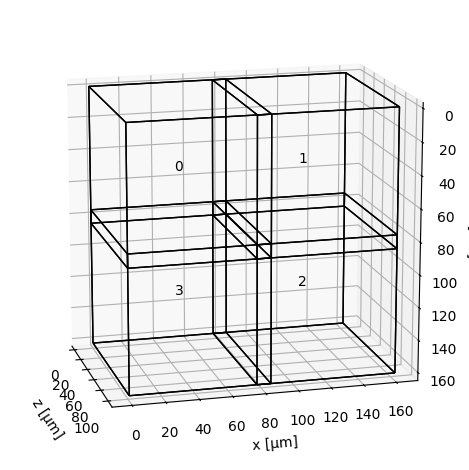

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='z [μm]', ylabel='x [μm]', zlabel='y [μm]'>)

In [13]:
translations = []
for itile, tile in enumerate(tiles):
    tile_grid_position = get_tile_grid_position_from_tile_index(itile)
    translations.append(
        {
            dim: tile_grid_position[dim] * (1 - (overlap[dim] if dim in overlap else 1)) * tile_shape[dim] * scale[dim]
            for dim in scale
        }
    )

print("Tile positions:")
print("\n".join([f"Tile {itile}: " + str(t) for itile, t in enumerate(translations)]))

# visualize the tile positions
# uncomment the following line to have an interactive 3D visualization (requires `ipympl` to be installed)
# %matplotlib ipympl
vis_utils.plot_positions(
    [msi_utils.get_msim_from_sim(si_utils.get_sim_from_array(
        da.zeros([tile_shape[dim] for dim in scale]), dims=list(scale.keys()), scale=scale, translation=translations[i]))
        for i in range(len(tiles))],
    use_positional_colors=False,
    transform_key=io.METADATA_TRANSFORM_KEY,
)

In [14]:
translations

[{'z': 0.0, 'y': 0.0, 'x': 0.0},
 {'z': 0.0, 'y': 0.0, 'x': 76.563},
 {'z': 0.0, 'y': 76.563, 'x': 76.563},
 {'z': 0.0, 'y': 76.563, 'x': 0.0}]

In [15]:
# Read input tiles and convert to OME-Zarr files
overwrite = False

msims = []
zarr_paths = []
for itile, tile in tqdm(enumerate(filelist_tiles)):

    # where to save the zarr(s)
    zarr_path = os.path.join(os.path.dirname(get_filename_from_tile_and_channel(tile)), filelist_tiles_save[itile]+'.zarr')

    print(zarr_path)

    # read tile image
    if os.path.exists(zarr_path) and not overwrite:
        im_data = da.from_zarr(os.path.join(zarr_path, '0'))[0] # drop t axis automatically added
    else:
        # im_data = tifffile.imread(get_filename_from_tile_and_channel(tile))
        file_path = str(data_path / tile)
        img = BioImage(
            file_path, 
            reader=bioio_czi.Reader, 
            reconstruct_mosaic=False,
            include_subblock_metadata=True,
            use_aicspylibczi=True,
        )
        im_data = img.get_image_data(img.dims.order[img.dims.order.index('T')+1:])

    sim = si_utils.get_sim_from_array(
        im_data,
        dims=["c", "z", "y", "x"],
        scale=scale,
        translation=translations[itile],
        transform_key=io.METADATA_TRANSFORM_KEY,
        )

    # write to OME-Zarr
    ngff_utils.write_sim_to_ome_zarr(sim, zarr_path, overwrite=overwrite)
    # replace sim with the sim read from the written OME-Zarr
    sim = ngff_utils.read_sim_from_ome_zarr(zarr_path)

    # alternatively `write_sim_to_ome_zarr` returns a sim loaded from the written OME-Zarr
    # sim = ngff_utils.write_sim_to_ome_zarr(sim, zarr_path, overwrite=overwrite)

    msim = msi_utils.get_msim_from_sim(sim)
    zarr_paths.append(zarr_path)

    msims.append(msim)

urls = zarr_paths

0it [00:00, ?it/s]

/mnt/Data/nuno_martins/Image_data/Ex010_Re01/ExM/20250417_2/Airyscan_processed/split_czi/gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan_Processing-07_2_tile01.zarr
/mnt/Data/nuno_martins/Image_data/Ex010_Re01/ExM/20250417_2/Airyscan_processed/split_czi/gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan_Processing-07_2_tile02.zarr
/mnt/Data/nuno_martins/Image_data/Ex010_Re01/ExM/20250417_2/Airyscan_processed/split_czi/gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan_Processing-07_2_tile03.zarr
/mnt/Data/nuno_martins/Image_data/Ex010_Re01/ExM/20250417_2/Airyscan_processed/split_czi/gel4c_-01-5_AcquisitionBlock4_pt4_sub1-Scene-1-Airyscan_Processing-07_2_tile04.zarr


In [16]:
sim

<xarray.DataArray 'image' (t: 1, c: 3, z: 260, y: 1810, x: 1810)> Size: 5GB
dask.array<from-zarr, shape=(1, 3, 260, 1810, 1810), dtype=uint16, chunksize=(1, 1, 256, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * t        (t) int64 8B 0
  * z        (z) float64 2kB 0.0 0.4 0.8 1.2 1.6 ... 102.4 102.8 103.2 103.6
  * y        (y) float64 14kB 76.56 76.61 76.66 76.7 ... 161.4 161.5 161.5 161.6
  * x        (x) float64 14kB 0.0 0.047 0.094 0.141 ... 84.88 84.93 84.98 85.02
  * c        (c) <U1 12B '0' '1' '2'
Attributes:
    transforms:  {'affine_metadata': <xarray.DataArray (t: 1, x_in: 4, x_out:...

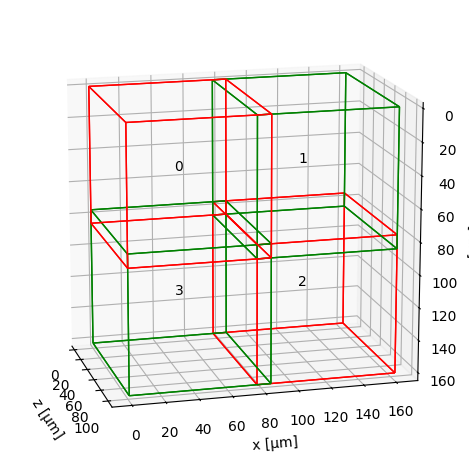

In [17]:
# visualize tile positions/configuration

# uncomment the following line for 3D interactivity with the plot (requires ipympl to be installed)
# % matplotlib widget

from multiview_stitcher import vis_utils

fig, ax = vis_utils.plot_positions(
    msims,
    use_positional_colors=True, # set to False for faster execution in case of more than 20 tiles/views
    transform_key='affine_metadata'
    )

In [18]:
# Turn channel alignment on or off
perform_channel_alignment = False

# Channel alignment is performed using a single tile.
# Choose here which tile (index) to use.
channel_alignment_tile_index = 0

curr_transform_key = 'affine_metadata'
if perform_channel_alignment:
    curr_transform_key = 'affine_metadata_ch_reg'

    channels = msims[channel_alignment_tile_index]['scale0/image'].coords['c']

    # select chosen tiles for registration
    msims_ch_reg = [msi_utils.multiscale_sel_coords(msims[5], {'c': ch})
                    for ch in channels]

    with dask.diagnostics.ProgressBar():
        params_c = registration.register(
            msims_ch_reg,
            registration_binning={'z': 2, 'y': 4, 'x': 4},
            reg_channel_index=0,
            transform_key='affine_metadata',
            pre_registration_pruning_method=None,
        )

    # assign channel coordinates to obtained parameters
    params_c = xr.concat(params_c, dim='c').assign_coords({'c': channels})

    # set obtained parameters for all tiles
    for msim in msims:
        msi_utils.set_affine_transform(
            msim, params_c, transform_key=curr_transform_key, base_transform_key='affine_metadata')

In [25]:
with dask.diagnostics.ProgressBar():

    params = registration.register(
        msims,
        registration_binning={'z': 1, 'y': 3, 'x': 3},
        reg_channel_index=0,
        transform_key=curr_transform_key,
        new_transform_key='affine_registered',
        pre_registration_pruning_method="keep_axis_aligned", # works well for tiles on a grid
    )

[########################################] | 100% Completed | 826.43 ms
[########################################] | 100% Completed | 38.26 ss
[########################################] | 100% Completed | 17.30 ss
[########################################] | 100% Completed | 30.06 ss
[########################################] | 100% Completed | 35.69 ss


### Print the obtained parameters.
How to interpret them?

parameters are expressed as homogeneous matrices of dimensions (n+1, n+1)
- the first n rows and columns correspond to the linear part of the transformation
- the first three elements of the last column correspond to the translation in (z, y, x)
- the parameters map the coordinates of the input files (considering their scale and translation) into a world coordinate system in which the tiles are registered

In [26]:
for imsim, msim in enumerate(msims):
    affine = np.array(msi_utils.get_transform_from_msim(msim, transform_key='affine_registered')[0])
    print(f'tile index {imsim}\n', affine)

tile index 0
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  3.80000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -1.83300000e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.09276247e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
tile index 1
 [[  1.       0.       0.     -37.6   ]
 [  0.       1.       0.      -0.0705]
 [  0.       0.       1.      -0.9165]
 [  0.       0.       0.       1.    ]]
tile index 2
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
tile index 3
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -7.60000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -1.83300000e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.09276247e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Fuse views (linear blending)
Save output into OME-ZARR

In [27]:
output_dir = save_path
output_filename = os.path.join(output_dir, 'fused.zarr')

fused = fusion.fuse(
    [msi_utils.get_sim_from_msim(msim) for msim in msims],
    transform_key='affine_registered',
    output_chunksize=256,
    )

print(f'Fusing views and saving output to {output_filename}...')
with dask.diagnostics.ProgressBar():
    fused = ngff_utils.write_sim_to_ome_zarr(
        fused, output_filename, overwrite=True
    )

Fusing views and saving output to /mnt/Data/nuno_martins/Image_data/Ex010_Re01/ExM/20250417_2/Airyscan_processed/split_czi/stitched_files/fused.zarr...
[########################################] | 100% Completed | 215.61 s
[########################################] | 100% Completed | 6.97 sms
[########################################] | 100% Completed | 929.56 ms
[########################################] | 100% Completed | 203.96 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 100.88 ms
[########################################] | 100% Completed | 100.89 ms
[########################################] | 100% Completed | 101.72 ms
[########################################] | 100% Completed | 101.47 ms
[########################################] | 100% Completed | 101.43 ms
[########################################] | 100% Completed | 101.44 ms
